# hypopy tutorial, P and S wave data

## Outline

- [Create synthetic data](#Create-synthetic-data)
- [Initial hypocenter locations](#Initial-hypocenter-locations)
- [Velocity data points](#Velocity-data-points)
- [Calibration shots](#Calibration-shots)
- [Constant velocity inversion](#Constant-velocity-inversion)
- [Joint hypocenter-velocity inversion parameters](#Joint-hypocenter-velocity-inversion-parameters)
- [Joint hypocenter-velocity inversion](#Joint-hypocenter-velocity-inversion)
- [Results](#Results)


In [2]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import hypo

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Create first synthetic data

Define limits and build grid.  In this example, we will use units of kilometers for distances.

In [3]:
xmin = 0.090
xmax = 0.211
ymin = 0.080
ymax = 0.211
zmin = 0.0
zmax = 0.101

dx = 0.0075   # grid cell size, we use cubic cells here

x = np.arange(xmin, xmax, dx)
y = np.arange(ymin, ymax, dx)
z = np.arange(zmin, zmax, dx)

nthreads = 4   # do calculations in parallel with 4 processes
g = hypo.Grid3D(x, y, z, nthreads)

We need some receivers

In [4]:
rcv = np.array([[0.112, 0.115, 0.013],
                [0.111, 0.116, 0.040],
                [0.111, 0.113, 0.090],
                [0.151, 0.117, 0.017],
                [0.180, 0.115, 0.016],
                [0.113, 0.145, 0.011],
                [0.160, 0.150, 0.017],
                [0.185, 0.149, 0.015],
                [0.117, 0.184, 0.011],
                [0.155, 0.192, 0.009],
                [0.198, 0.198, 0.010],
                [0.198, 0.196, 0.040],
                [0.198, 0.193, 0.090]])
ircv = np.arange(rcv.shape[0]).reshape(-1,1)   # vector of rcv indices
nsta = rcv.shape[0]

Let's create 15 events randomly located in the grid

In [5]:
nev = 15
src = np.vstack((np.arange(nev),                                            # event ID
                 np.linspace(0., 50., nev) + np.random.randn(nev),          # origin time
                 0.160 + 0.005*np.random.randn(nev),                           # x
                 0.140 + 0.005*np.random.randn(nev),                           # y
                 0.060 + 0.010*np.random.randn(nev))).T                        # z

h_true = src.copy()

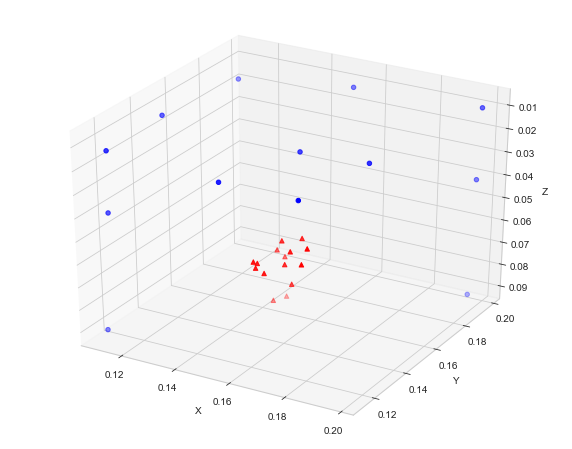

In [6]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rcv[:,0], rcv[:,1], rcv[:,2], c='b', marker='o')
ax.scatter(src[:,2], src[:,3], src[:,4], c='r', marker='^')
ax.invert_zaxis()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

For simplicity, we will use a velocity model with a small vertical gradient and mean Vp = 4000 m/s, and a constant velocity model for Vs

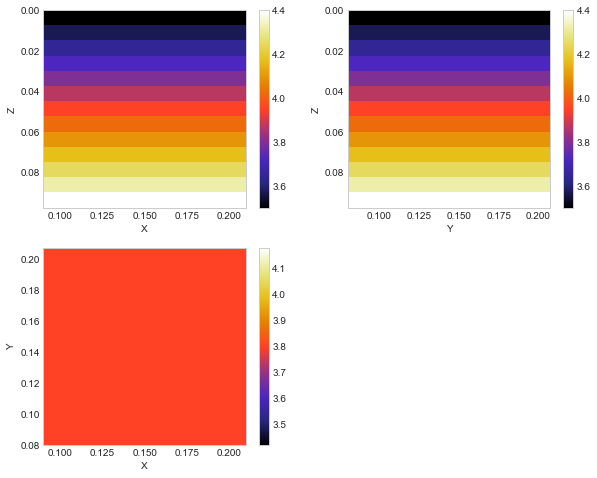

In [7]:
def Vz(z):
    return 4.0 + 10.0*(z-0.050)
Vp = np.kron(Vz(z), np.ones((g.shape[0], g.shape[1], 1)))

Vs = 2.1

plt.figure(figsize=(10,8))
plt.subplot(221)
plt.pcolor(x,z,np.squeeze(Vp[:,0,:].T), cmap='CMRmap',), plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Z')
plt.colorbar()
plt.subplot(222)
plt.pcolor(y,z,np.squeeze(Vp[0,:,:].T), cmap='CMRmap'), plt.gca().invert_yaxis()
plt.xlabel('Y')
plt.ylabel('Z')
plt.colorbar()
plt.subplot(223)
plt.pcolor(x,y,np.squeeze(Vp[:,:,4].T), cmap='CMRmap')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()

plt.show()

Let's now compute the travel times

The raytracing routine takes 3 input variables:
- the slowness vector (ordered in 'C' order)
- the matrix of hypocenter data (hypo)
- the matrix of receiver coordonates (rcv)

hypo and rcv must have the same number of rows, with each row corresponding to a source-receiver pair

In [8]:
slowness = 1./Vp.flatten()
slowness_s = 1./Vs + np.zeros(g.getNumberOfNodes())

src = np.kron(src,np.ones((nsta,1)))   # use kron to replicate src-rcv pairs correctly
rcv_data = np.kron(np.ones((nev,1)), rcv)
ircv_data = np.kron(np.ones((nev,1)), ircv)

In [9]:
# call the actual raytracing method

tt = g.raytrace(slowness, src, rcv_data)
tt_s = g.raytrace(slowness_s, src, rcv_data)

Add some noise to the data

In [10]:
noise_variance = 1.e-3;  # 1 ms
tt += noise_variance*np.random.randn(tt.size)
tt_s += noise_variance*np.random.randn(tt_s.size)

Combine the event IDs, travel times, and receiver locations, after removing some values randomly

In [11]:
# remove some values
ind_p = np.ones(tt.shape[0], dtype=bool)
ind_p[np.random.randint(ind_p.size,size=25)] = False
ind_s = np.ones(tt_s.shape[0], dtype=bool)
ind_s[np.random.randint(ind_s.size,size=25)] = False

data_p = np.hstack((src[ind_p,0].reshape((-1,1)), tt[ind_p].reshape((-1,1)), ircv_data[ind_p,:], np.zeros((np.sum(ind_p),1))))
data_s = np.hstack((src[ind_s,0].reshape((-1,1)), tt_s[ind_s].reshape((-1,1)), ircv_data[ind_s,:], np.ones((np.sum(ind_s),1))))

data = np.vstack((data_p, data_s))

## Initial hypocenter locations

Note that for efficiency reason when computing matrix M, initial hypocenters
should _not_ be equal for any two event, e.g. they shoud all be different.

Here we place the initial coordinates more or less in the center of the grid.

In [12]:
hinit = np.vstack((np.arange(nev),
                   np.linspace(0., 50., nev),
                   0.150 + 0.0001*np.random.randn(nev),
                   0.150 + 0.0001*np.random.randn(nev),
                   0.050 + 0.0001*np.random.randn(nev))).T

## Velocity data points

For illustrative purposes, let's add a couple of velocity data points to constrain the inversion

In [13]:
Vpts = np.array([[Vz(0.001), 0.100, 0.100, 0.001, 0.0],
                 [Vz(0.001), 0.100, 0.200, 0.001, 0.0],
                 [Vz(0.001), 0.200, 0.100, 0.001, 0.0],
                 [Vz(0.001), 0.200, 0.200, 0.001, 0.0],
                 [Vz(0.011), 0.112, 0.148, 0.011, 0.0],
                 [Vz(0.005), 0.152, 0.108, 0.005, 0.0],
                 [Vz(0.075), 0.152, 0.108, 0.075, 0.0],
                 [Vz(0.011), 0.192, 0.148, 0.011, 0.0],
                 [Vs, 0.100, 0.100, 0.001, 1.0],
                 [Vs, 0.100, 0.200, 0.001, 1.0],
                 [Vs, 0.200, 0.100, 0.001, 1.0],
                 [Vs, 0.200, 0.200, 0.001, 1.0],
                 [Vs, 0.112, 0.148, 0.011, 1.0],
                 [Vs, 0.152, 0.108, 0.005, 1.0],
                 [Vs, 0.152, 0.108, 0.075, 1.0],
                 [Vs, 0.192, 0.148, 0.011, 1.0]])

## Calibration shots

Let's use 5 shots recorded at most receivers

In [14]:
ncal = 5
src_cal = np.vstack((5+np.arange(ncal),
                 np.zeros(ncal),
                 0.160 +  0.005*np.random.randn(ncal),
                 0.130 +  0.005*np.random.randn(ncal),
                 0.045 +  0.005*np.random.randn(ncal))).T

src_cal = np.kron(src_cal,np.ones((nsta,1)))
rcv_cal = np.kron(np.ones((ncal,1)), rcv)
ircv_cal = np.kron(np.ones((ncal,1)), ircv)

ind = np.ones(rcv_cal.shape[0], dtype=bool)
ind[3] = 0
ind[13] = 0
ind[15] = 0
src_cal = src_cal[ind,:]
rcv_cal = rcv_cal[ind,:]
ircv_cal = ircv_cal[ind,:]

tcal = g.raytrace(slowness, src_cal, rcv_cal)
tcal_s = g.raytrace(slowness_s, src_cal, rcv_cal)
caldata_p = np.column_stack((src_cal[:,0], tcal, ircv_cal, src_cal[:,2:], np.zeros(tcal.shape)))
caldata_s = np.column_stack((src_cal[:,0], tcal_s, ircv_cal, src_cal[:,2:], np.ones(tcal_s.shape)))
caldata = np.vstack((caldata_p, caldata_s))

## Constant velocity inversion

Before running the joint hypocenter-velocity inversion (JHVI), we use the constant velocity location algorithm.  This will improve convergence of the JHVI.

Initial velocity model is of course homogeneous.  We take the mean value of the data points for Vp and a value a bit off for Vs.

In [15]:
Vinit = (np.mean(Vpts[:8,0]), 2.0)

hinit2, res = hypo.hypolocPS(data, rcv, V=Vinit, hinit=hinit, maxit=15, convh=0.001, verbose=True)


 *** Hypocenter inversion  --  P and S-wave data ***

Locating hypocenters no 0
     Converged at iteration 2
Locating hypocenters no 1
     Converged at iteration 3
Locating hypocenters no 2
     Converged at iteration 2
Locating hypocenters no 3
     Converged at iteration 2
Locating hypocenters no 4
     Converged at iteration 3
Locating hypocenters no 5
     Converged at iteration 3
Locating hypocenters no 6
     Converged at iteration 3
Locating hypocenters no 7
     Converged at iteration 3
Locating hypocenters no 8
     Converged at iteration 2
Locating hypocenters no 9
     Converged at iteration 3
Locating hypocenters no 10
     Converged at iteration 3
Locating hypocenters no 11
     Converged at iteration 2
Locating hypocenters no 12
     Converged at iteration 3
Locating hypocenters no 13
     Converged at iteration 2
Locating hypocenters no 14
     Converged at iteration 3

 ** Inversion complete **



Look now at error on hypocenter location

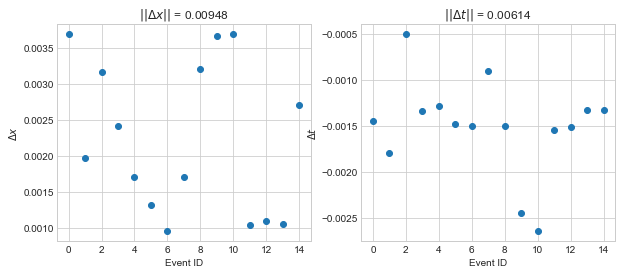

In [16]:
err_x = hinit2[:,2:5] - h_true[:,2:5]
err_x = np.sqrt(np.sum(err_x**2, axis=1))
err_t = hinit2[:,1] - h_true[:,1]

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(err_x,'o')
plt.ylabel(r'$\Delta x$')
plt.xlabel('Event ID')
plt.title(r'$\|\|\Delta x\|\|$ = {0:6.5f}'.format(np.linalg.norm(err_x)))
plt.subplot(122)
plt.plot(err_t,'o')
plt.ylabel(r'$\Delta t$')
plt.xlabel('Event ID')
plt.title(r'$\|\|\Delta t\|\|$ = {0:6.5f}'.format(np.linalg.norm(err_t)))

plt.show()

## Joint hypocenter-velocity inversion parameters

Define inversion parameters.  We will invert for $V_S$ rather than for $V_S/V_P$, the latter not being fully tested at this time.

In [17]:
Vpmin = 3.5
Vpmax = 4.5
PAp = 1.0
Vsmin = 1.9
Vsmax = 2.3
PAs = 1.0
Vlim = (Vpmin, Vpmax, PAp, Vsmin, Vsmax, PAs)
        
dVp_max = 0.1
dx_max = 0.010
dt_max = 0.01
dVs_max = 0.1
dmax = (dVp_max, dx_max, dt_max, dVs_max)
        
λ = 2.
γ = 1.
α = 1.
wzK = 0.1
lagran = (λ, γ, α, wzK)

par = hypo.InvParams(maxit=5, maxit_hypo=10, conv_hypo=0.001, Vlim=Vlim, dmax=dmax,
                     lagrangians=lagran, invert_vel=True, invert_VsVp=False, verbose=True)

Let's build an initial velocity model slightly off the true one

In [18]:
def Vz2(z):
    return 4. + 7.5*(z-0.050)

Vpinit = np.kron(Vz2(z), np.ones((g.shape[0], g.shape[1], 1)))
Vpinit = Vpinit.flatten()
Vinit = (Vpinit, 2.0)

## Joint hypocenter-velocity inversion

Run the inversion


 *** Joint hypocenter-velocity inversion  -- P and S-wave data ***

Building velocity data point matrix D
Building regularization matrix K

Starting iterations

Iteration 1 - Updating velocity model
                Updating penalty vector
                Raytracing


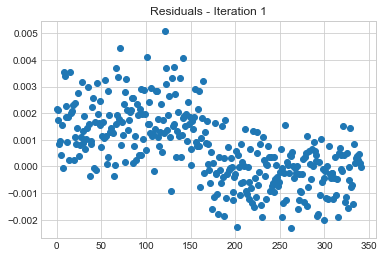

                Building matrix M
                  Event ID 0
                  Event ID 1
                  Event ID 2
                  Event ID 3
                  Event ID 4
                  Event ID 5
                  Event ID 6
                  Event ID 7
                  Event ID 8
                  Event ID 9
                  Event ID 10
                  Event ID 11
                  Event ID 12
                  Event ID 13
                  Event ID 14
                Assembling matrices and solving system
                  calling minres with system of size 8594 x 8594
Iteration 1 - Relocating events
                Updating event ID 0 (1/15)
                  Updating all hypocenter params                Updating event ID 4 (5/15)
                  Updating all hypocenter params                Updating event ID 8 (9/15)
                  Updating all hypocenter params                Updating event ID 12 (13/15)
                  Updating all hypocenter params - conve

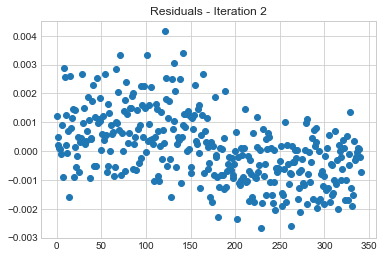

                Building matrix M
                  Event ID 0
                  Event ID 1
                  Event ID 2
                  Event ID 3
                  Event ID 4
                  Event ID 5
                  Event ID 6
                  Event ID 7
                  Event ID 8
                  Event ID 9
                  Event ID 10
                  Event ID 11
                  Event ID 12
                  Event ID 13
                  Event ID 14
                Assembling matrices and solving system
                  calling minres with system of size 8594 x 8594
Iteration 2 - Relocating events
                Updating event ID 0 (1/15)
                  Updating all hypocenter params                Updating event ID 4 (5/15)
                  Updating all hypocenter params                Updating event ID 8 (9/15)
                  Updating all hypocenter params                Updating event ID 12 (13/15)
                  Updating all hypocenter params - conve

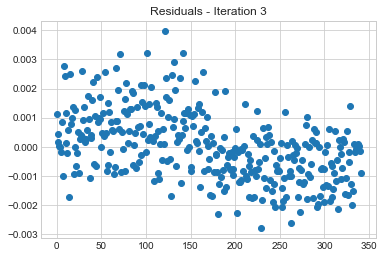

                Building matrix M
                  Event ID 0
                  Event ID 1
                  Event ID 2
                  Event ID 3
                  Event ID 4
                  Event ID 5
                  Event ID 6
                  Event ID 7
                  Event ID 8
                  Event ID 9
                  Event ID 10
                  Event ID 11
                  Event ID 12
                  Event ID 13
                  Event ID 14
                Assembling matrices and solving system
                  calling minres with system of size 8594 x 8594
Iteration 3 - Relocating events
                Updating event ID 0 (1/15)
                  Updating all hypocenter params                Updating event ID 4 (5/15)
                  Updating all hypocenter params                Updating event ID 8 (9/15)
                  Updating all hypocenter params                Updating event ID 12 (13/15)
                  Updating all hypocenter params - conve

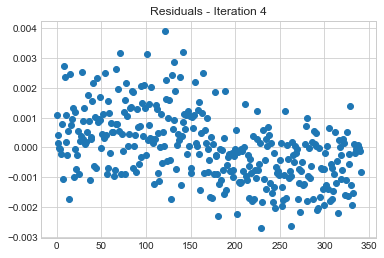

                Building matrix M
                  Event ID 0
                  Event ID 1
                  Event ID 2
                  Event ID 3
                  Event ID 4
                  Event ID 5
                  Event ID 6
                  Event ID 7
                  Event ID 8
                  Event ID 9
                  Event ID 10
                  Event ID 11
                  Event ID 12
                  Event ID 13
                  Event ID 14
                Assembling matrices and solving system
                  calling minres with system of size 8594 x 8594
Iteration 4 - Relocating events
                Updating event ID 0 (1/15)
                  Updating all hypocenter params                Updating event ID 4 (5/15)
                  Updating all hypocenter params                Updating event ID 8 (9/15)
                  Updating all hypocenter params                Updating event ID 12 (13/15)
                  Updating all hypocenter params - conve

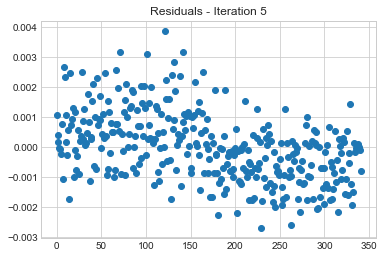

                Building matrix M
                  Event ID 0
                  Event ID 1
                  Event ID 2
                  Event ID 3
                  Event ID 4
                  Event ID 5
                  Event ID 6
                  Event ID 7
                  Event ID 8
                  Event ID 9
                  Event ID 10
                  Event ID 11
                  Event ID 12
                  Event ID 13
                  Event ID 14
                Assembling matrices and solving system
                  calling minres with system of size 8594 x 8594
Iteration 5 - Relocating events
                Updating event ID 0 (1/15)
                  Updating all hypocenter params                Updating event ID 4 (5/15)
                  Updating all hypocenter params                Updating event ID 8 (9/15)
                  Updating all hypocenter params                Updating event ID 12 (13/15)
                  Updating all hypocenter params - conve

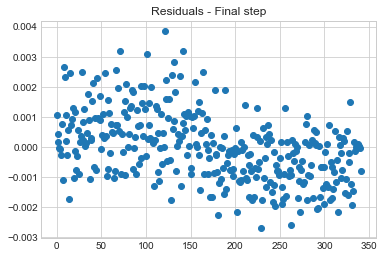


 ** Inversion complete **



In [19]:
h, V, sc, res = hypo.jointHypoVelPS(par, g, data, rcv, Vinit, hinit2, caldata=caldata, Vpts=Vpts)

## Results

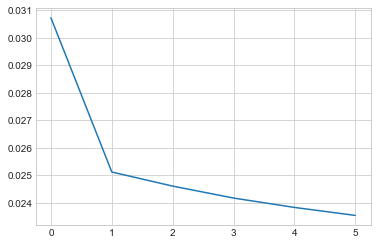

In [20]:
plt.plot(res[0])
plt.show()

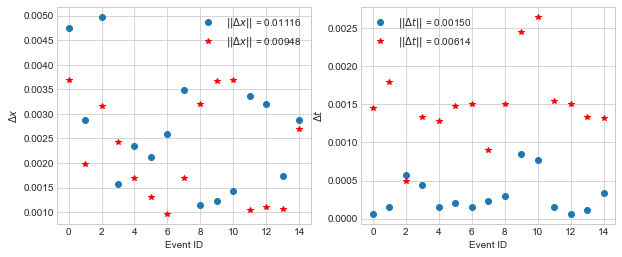

In [21]:
err_xc = hinit2[:,2:5] - h_true[:,2:5]
err_xc = np.sqrt(np.sum(err_xc**2, axis=1))
err_tc = hinit2[:,1] - h_true[:,1]

err_x = h[:,2:5] - h_true[:,2:5]
err_x = np.sqrt(np.sum(err_x**2, axis=1))
err_t = h[:,1] - h_true[:,1]

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(err_x,'o',label=r'$\|\|\Delta x\|\|$ = {0:6.5f}'.format(np.linalg.norm(err_x)))
plt.plot(err_xc,'r*',label=r'$\|\|\Delta x\|\|$ = {0:6.5f}'.format(np.linalg.norm(err_xc)))
plt.ylabel(r'$\Delta x$')
plt.xlabel('Event ID')
plt.legend()
plt.subplot(122)
plt.plot(np.abs(err_t),'o',label=r'$\|\|\Delta t\|\|$ = {0:6.5f}'.format(np.linalg.norm(err_t)))
plt.plot(np.abs(err_tc),'r*',label=r'$\|\|\Delta t\|\|$ = {0:6.5f}'.format(np.linalg.norm(err_tc)))
plt.ylabel(r'$\Delta t$')
plt.xlabel('Event ID')
plt.legend()

plt.show()

We can see a little improvement on relocation over constant velocity inversion, mainly for the origin time.  What about the velocity model?

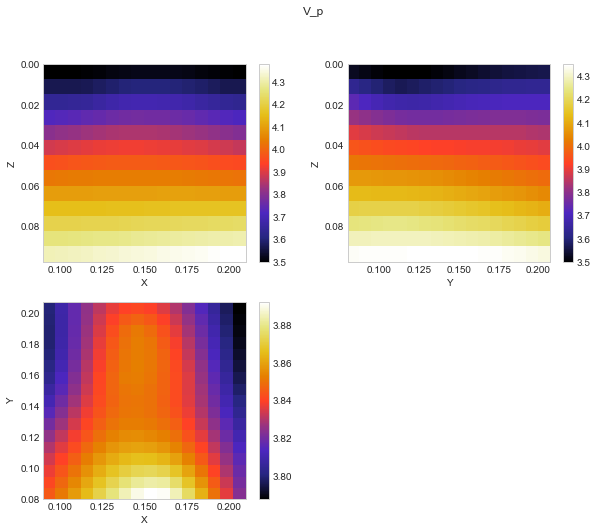

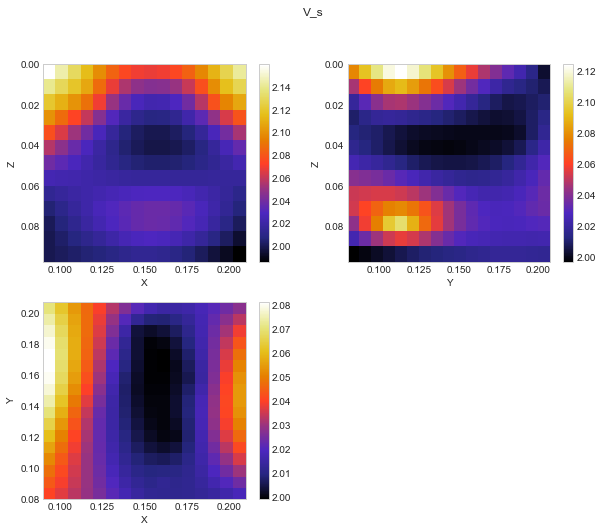

In [22]:
V3d = V[0].reshape(g.shape)

plt.figure(figsize=(10,8))
plt.subplot(221)
plt.pcolor(x,z,np.squeeze(V3d[:,9,:].T), cmap='CMRmap',), plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Z')
plt.colorbar()
plt.subplot(222)
plt.pcolor(y,z,np.squeeze(V3d[8,:,:].T), cmap='CMRmap'), plt.gca().invert_yaxis()
plt.xlabel('Y')
plt.ylabel('Z')
plt.colorbar()
plt.subplot(223)
plt.pcolor(x,y,np.squeeze(V3d[:,:,4].T), cmap='CMRmap')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
plt.suptitle('V_p')

V3d = V[1].reshape(g.shape)

plt.figure(figsize=(10,8))
plt.subplot(221)
plt.pcolor(x,z,np.squeeze(V3d[:,9,:].T), cmap='CMRmap',), plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Z')
plt.colorbar()
plt.subplot(222)
plt.pcolor(y,z,np.squeeze(V3d[8,:,:].T), cmap='CMRmap'), plt.gca().invert_yaxis()
plt.xlabel('Y')
plt.ylabel('Z')
plt.colorbar()
plt.subplot(223)
plt.pcolor(x,y,np.squeeze(V3d[:,:,4].T), cmap='CMRmap')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
plt.suptitle('V_s')


plt.show()

Let's look at station corrections

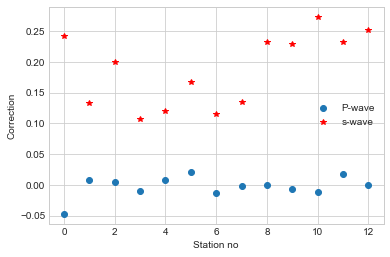

In [23]:
plt.plot(sc[0],'o',label='P-wave')
plt.plot(sc[1],'r*',label='s-wave')
plt.xlabel('Station no')
plt.ylabel('Correction')
plt.legend()
plt.show()

These results show that efforts should be put in estimating the initial the S wave velocity.